In [18]:
# first lets import the neccessay modules

import numpy as np
import scipy
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import h5py
# to display the image on jupyter 
%matplotlib inline  

In [3]:
# Load the dataset that we will be working on
# help(h5py.File)
def load_dataset():
    # train_data
    with h5py.File('Datasets/train_catvnoncat.h5', 'r') as train_data:
        train_x = np.array(train_data['train_set_x'][:])
        train_y = np.array(train_data['train_set_y'][:])
        # print(train_x.shape) # have good shape
        # print(train_y.shape) # shape is (209,) not good for vectorization
        train_y = train_y.reshape((1, train_y.shape[0]))
    # test data
    with h5py.File('Datasets/test_catvnoncat.h5','r') as test_data:
        test_x = np.array(test_data['test_set_x'][:])
        test_y = np.array(test_data['test_set_y'][:])
        # reshape the test_y just like the train set
        test_y = test_y.reshape((1, test_y.shape[0]))
    return (train_x, train_y, test_x, test_y)

The shape of train_x set is (209, 64, 64, 3)
The shape of train_y set is (1, 209)
The shape of test_x set is (50, 64, 64, 3)
The shape of test_y set is (1, 50)


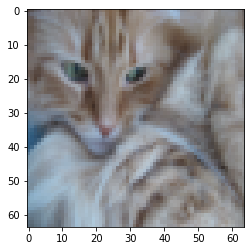

1


In [4]:
train_x, train_y,test_x, test_y = load_dataset()
num_px = train_x.shape[1]
# to check the dimensions of each set
print('The shape of train_x set is {}'.format(train_x.shape))
print('The shape of train_y set is {}'.format(train_y.shape))
print('The shape of test_x set is {}'.format(test_x.shape))
print('The shape of test_y set is {}'.format(test_y.shape))
# display random image from training set
plt.imshow(train_x[2])
plt.show()
# display coresponding Label
print(train_y[0][2])

In [5]:
# reshape the train and data(X.shape(nx,m)) where nx is the number of features and m num of training example

train_x_flatten = train_x.reshape(train_x.shape[0],-1).T
test_x_flatten = test_x.reshape(test_x.shape[0],-1).T
print('Flatten train dataset dimension is now {}'.format(train_x.shape))
print('Flatten test dataset dimension is now {}'.format(test_x.shape))

Flatten train dataset dimension is now (209, 64, 64, 3)
Flatten test dataset dimension is now (50, 64, 64, 3)


In [6]:
# now let's standaridize the dataset
# more about standardization and normalization on https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
train_x_standardized = train_x_flatten/255
test_x_standardized = test_x_flatten/255

In [7]:
#impostant functions

def sigmoid(z):
    # z = w.T X + b -> which is (1, m)
    s = 1/(1 + np.exp(-z)) # s is (1,m)
    
    return s


def initialize_params(dim):
    ''' Input:
            dim - is the number of input feature(#pixels)
        Outputs:
            w - weight vector with size (dim, 1)
            b - bias scalar(zero)
    '''
    # initialize weight with vector of small random numbers
    w = np.random.randn(dim,1)*0.001
    # initialize bias with zero
    b = 0
    return w, b
def forward_propagate(w, b, X):
    ''' Inputs:
            w - 12288x1 weight vector
            b - scalar
            X - 12288x209 numpy array-- 209 images of size 12288x1 stacked together in column 
        Output:
            A - 1x209 vector returned form sigmoid function
    '''
    # compute z
    z = np.dot(w.T, X) + b
    # compute activation using sigmoid function
    A = sigmoid(z)
    return A

def predict(w, b, X):
    ''' Inputs:
            w - 12288x1 weight vector(optimized)
            b - scalar (optimized)
            X - 12288xN numpy array-- N images of size 12288x1 stacked together in column 
        Output:
            predictions - 1xN vector containing of predicted labels for images in X
    '''
    # create vector same size as # of examples-(1, X.shape[1])
    predictions = np.zeros((1, X.shape[1]))
    A = forward_propagate(w, b, X)
    for i in range(A.shape[1]):
        if A[0,i] <= 0.5 :
            predictions[0,i] = 0
        else:
            predictions[0,i] = 1
    return predictions

def backward_propagation(X, A, Y):
    ''' Inputs:
            X - 12288x209 sized training set
            A - 1x209 vector of containing the output of forward pass
            Y - 1x209 vector having true labels of each images in X
        Outputs:
            cost - scalar value
            grads - computed gradients(dw, db) as dictionary
    '''
    m = X.shape[1]
    cost = (-1/m)* np.sum(np.dot(np.log(A),Y.T)  + np.dot(np.log(1-A), (1-Y.T))) 
    # backward
    dz = (A-Y)
    dw = (1/m)*np.dot(X, dz.T)
    db = (1/m)*(np.sum(dz))
    grad = {'db':db,'dw': dw}
    cost = float(np.squeeze(cost)) 
    
    return cost, grad

def optimize(w,b,X,Y, num_iterations, learning_rate, print_cost = False):
    ''' Inputs:
            w - a 12288x1 weight vector to be optimized
            b - a scalar bias value to be optimized
            X - 12288x209 training set
            Y - 1x209 true labels of 209 images in X
            num_iterations - is a scalar, # iteration for gradient descent to iterate
            learning_rate - scalar used to control the gradient descent update
            print_cost - boolean to decide whether to print or not cost during training
        Outputs:
            params - dictionary containing weights and bias
            cost - list of all costs computed in each iteration
            grads - dictionary of gradients computed using backpropagation
    
    '''
    costs = []
    
    for i in range(num_iterations):
        A = forward_propagate(w, b, X)
        cost,grads = backward_propagation(X, A, Y)
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # cost in each 100 iterations
        if i % 500 == 0:
            costs.append(cost)
            if print_cost:
                print('cost at itration {} is {}'.format(i, cost))
            # else:
                # print('.', end='')
                
        grads = {'dw': dw, 'db':db}
        params = {'w':w, 'b':b}
        
    return params, costs, grads


def model(train_x,train_y, test_x, test_y, num_iterations, learning_rate, print_cost):
    w, b = initialize_params(train_x.shape[0])
    params, costs, grads = optimize(w,b, train_x, train_y, num_iterations, learning_rate, print_cost )
    w = params['w']
    b = params['b']
    dw = grads['dw']
    db = grads['db']
    
    train_predictions = predict(w, b, train_x_standardized)
    test_predictions = predict(w, b, test_x_standardized)
    
    print('\nTrain Accuracy: {}'.format(100 - np.mean(np.abs(train_y - train_predictions))*100))
    print('Train Accuracy: {}'.format(100 - np.mean(np.abs(test_y - test_predictions))*100))
    checkpoint = {'train_pred':train_predictions,
                 'test_pred':test_predictions,
                 'costs':costs,
                 'w':w,
                 'b':b,
                 'learning_rate':learning_rate,
                 'num_iterations':num_iterations}
    
    return checkpoint


In [15]:
# now we have the functions neccessary

checkpoint = model(train_x_standardized, train_y, test_x_standardized, test_y, num_iterations = 5000,learning_rate = 0.001, print_cost = True)

cost at itration 0 is 0.705717222502847
cost at itration 500 is 0.48849285824726124
cost at itration 1000 is 0.4186869472588393
cost at itration 1500 is 0.370936077327642
cost at itration 2000 is 0.33473849149194734
cost at itration 2500 is 0.3058240987219765
cost at itration 3000 is 0.281947815949777
cost at itration 3500 is 0.26176627353089477
cost at itration 4000 is 0.24440723468730527
cost at itration 4500 is 0.22927095650098342

Train Accuracy: 97.12918660287082
Train Accuracy: 74.0


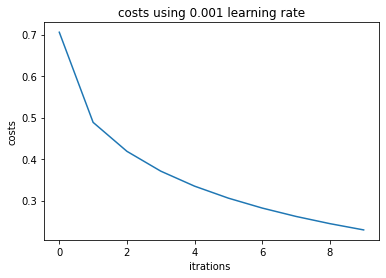

the cost initially was 0.705717222502847, then it is minized to 0.22927095650098342


In [16]:
costs = checkpoint['costs']
plt.plot(costs)
plt.xlabel('itrations ')
plt.ylabel('costs')
plt.title('costs using {} learning rate'.format(checkpoint['learning_rate']))
plt.show()
print('the cost initially was {}, then it is minized to {}'.format(costs[0], costs[-1]))

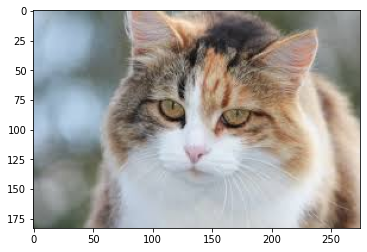

y = 1.0, your algorithm predicts a "cat" picture.


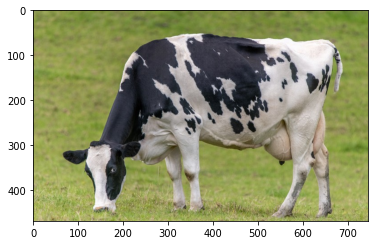

y = 0.0, your algorithm predicts a "non cat" picture.


In [19]:
classes = {1:'cat', 0:'non cat'}
fname1 = 'cat.jpeg' 
fname2 = 'cow.jpg' 
image1 = np.array(imread(fname1))
image2 = np.array(imread(fname2))
plt.imshow(image1)
plt.show()
# We preprocess the image to fit your algorithm.
my_image = np.array(Image.fromarray(image1).resize([num_px,num_px])).reshape((1, num_px*num_px*3)).T
my_image = my_image/255
my_predicted_image = predict(checkpoint["w"], checkpoint["b"], my_image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image))] +  "\" picture.")

plt.imshow(image2)
plt.show()
# We preprocess the image to fit your algorithm.
my_image = np.array(Image.fromarray(image2).resize([num_px,num_px])).reshape((1, num_px*num_px*3)).T
my_image = my_image/255
my_predicted_image = predict(checkpoint["w"], checkpoint["b"], my_image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image))] +  "\" picture.")